<a href="https://colab.research.google.com/github/nat-tsang/computer-vision-bootcamp/blob/master/NT_WARG_CV_bootcamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Files already downloaded and verified
images.shape: torch.Size([128, 3, 32, 32])


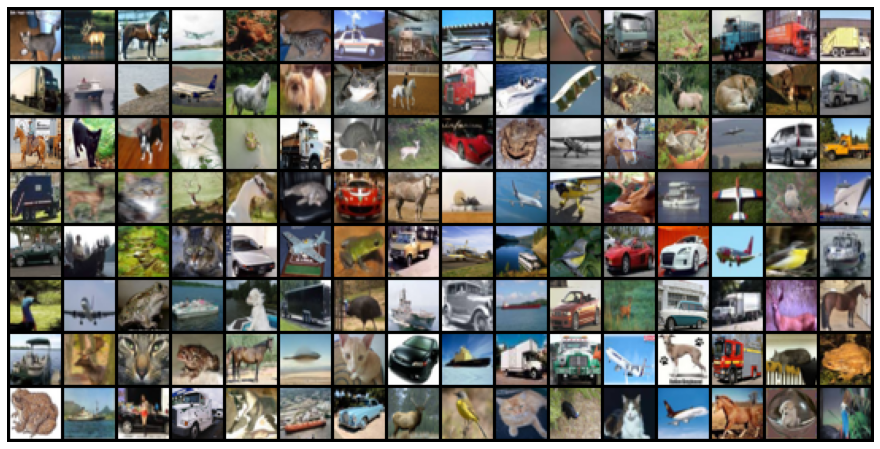

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision 
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from  torch.utils.data import random_split

dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform = ToTensor())

#collect 10 classes 
classes = dataset.classes
class_count = {}

#loop through to see how many images are in each class
for v, index in dataset:
  label = classes[index]
  if label not in class_count:
    class_count[label] = 0
  class_count[label] +=1

torch.manual_seed(43) #ensures we get the same validation set each time (validation set contains 5000 images, 10% of the dataset)
val_size = 500
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

batch_size = 128


train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True) #shuffle true so that batches generated in each epoch are different
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True) #validation loader is only for evaluating the model
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True) # made pin memory true in these so that the data is pushed from the CPU to the GPU

for images, v in train_loader: 
  print('images.shape:', images.shape)
  plt.figure(figsize=(16, 8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
  break

#MODEL
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds==labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
  def training_step(self, batch): 
    images, labels = batch
    out = self(images) # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss

  def validation_step(self, batch) :
    images, labels = batch
    out = self(images) #Generate predictions 
    loss = F.cross_entropy(out, labels) #Calculate loss
    acc = accuracy(out, labels) #Calculate accuracy
    return {'val_loss' : loss.detach(), 'val_accuracy' : acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean() #Combine losses
    batch_accs = [x['val_accuracy'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean() #Combine accuracies
    return {'val_loss': epoch_loss.item(),'val_accuracy': epoch_acc.item()}
  
  #summarizes end of epoch
  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch,result['val_loss'], result['val_accuracy']))


In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
#defines utilities and moves data to GPU if available
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
def plot_losses(history):
  losses = [x['val_loss'] for x in history]
  plt.plot(losses, '-x')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('Loss vs. No. of epochs');

def plot_accuracies(history):
  accuracies = [x['val_accuracy'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs')

In [ ]:
device = get_default_device()

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
#training the model
input_size = 3*32*32
output_size = 10

In [ ]:
class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        return out

In [ ]:
model = to_device(CIFAR10Model(), device)

history = [evaluate(model, val_loader)]
history += fit(30, 1e-1, model, train_loader, val_loader)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], val_loss: 1.8625, val_acc: 0.3390
Epoch [1], val_loss: 1.7641, val_acc: 0.3916
Epoch [2], val_loss: 1.6615, val_acc: 0.4175
Epoch [3], val_loss: 1.7519, val_acc: 0.4073
Epoch [4], val_loss: 1.6163, val_acc: 0.4403
Epoch [5], val_loss: 1.5639, val_acc: 0.4439
Epoch [6], val_loss: 1.5919, val_acc: 0.4175
Epoch [7], val_loss: 1.5856, val_acc: 0.4320
Epoch [8], val_loss: 1.5216, val_acc: 0.4817
Epoch [9], val_loss: 1.4674, val_acc: 0.4805
Epoch [0], val_loss: 1.5553, val_acc: 0.4603
Epoch [1], val_loss: 1.6132, val_acc: 0.4426
Epoch [2], val_loss: 1.4491, val_acc: 0.4757
Epoch [3], val_loss: 1.4822, val_acc: 0.4850
Epoch [4], val_loss: 1.4582, val_acc: 0.4941
Epoch [5], val_loss: 1.4343, val_acc: 0.5087
Epoch [6], val_loss: 1.4004, val_acc: 0.5103
Epoch [7], val_loss: 1.4162, val_acc: 0.5000
Epoch [8], val_loss: 1.4409, val_acc: 0.4923
Epoch [9], val_loss: 1.4554, val_acc: 0.5017
Epoch [0], val_loss: 1.4258, val_acc: 0.5082
Epoch [1], val_loss: 1.5416, val_acc: 0.4762
Epoch [2],

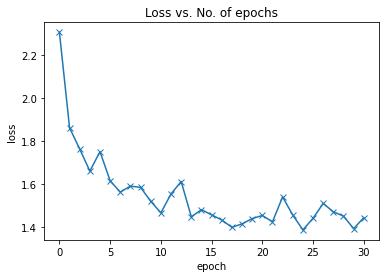

In [ ]:
plot_losses(history)


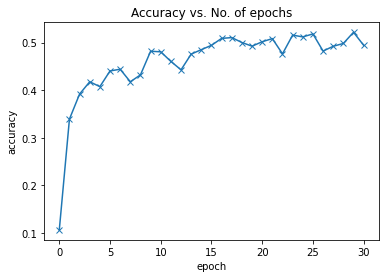

In [ ]:
plot_accuracies(history)